##Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)

###Load dataset:
In this project, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.

In [24]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

Let's also get the word indexs (word to word-id)

In [25]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [26]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [27]:
decode_review(X_train[0])

"<sos> i studied charlotte <oov> novel in high school and it left me with a stunning impression here was a beautiful novel about a young woman's struggle to find love and acceptance in the dark times of victorian england this young woman was jane eyre a poor and plain character with a strong mind and will of her own her story which <oov> told through jane's own eyes was both sad and inspiring br br as part of our study we watched the 1983 adaptation of the story and it blew me away the mini series not only made the effort to stay true to <oov> original text and the essence of the story but the actors who portrayed the characters were just great both zelah clarke jane eyre and timothy dalton jane's lover by the name of rochester captured brilliantly the essence of their characters i cannot imagine anyone else in their roles the other performances of rochester in other versions such as the 2006 version lack the passion energy and <oov> needed to portray rochester accurately i say that ti

In [28]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [29]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model:
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN)
- The output layer



In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 10)          100000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1376      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101409 (396.13 KB)
Trainable params: 101409 (396.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we have to train the model:

In [32]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
137/137 [==============================] - 83s 596ms/step - loss: 0.6909 - accuracy: 0.5294 - val_loss: 0.6834 - val_accuracy: 0.5741
Epoch 2/10
137/137 [==============================] - 79s 579ms/step - loss: 0.6341 - accuracy: 0.6746 - val_loss: 0.6495 - val_accuracy: 0.6109
Epoch 3/10
137/137 [==============================] - 75s 550ms/step - loss: 0.4581 - accuracy: 0.8090 - val_loss: 0.4171 - val_accuracy: 0.8237
Epoch 4/10
137/137 [==============================] - 73s 535ms/step - loss: 0.3109 - accuracy: 0.8731 - val_loss: 0.4174 - val_accuracy: 0.8211
Epoch 5/10
137/137 [==============================] - 72s 529ms/step - loss: 0.1797 - accuracy: 0.9363 - val_loss: 0.3907 - val_accuracy: 0.8449
Epoch 6/10
137/137 [==============================] - 73s 532ms/step - loss: 0.1061 - accuracy: 0.9687 - val_loss: 0.4177 - val_accuracy: 0.8461
Epoch 7/10
137/137 [==============================] - 71s 515ms/step - loss: 0.0544 - accuracy: 0.9875 - val_loss: 0.4740 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

782/782 - 30s - loss: 0.5240 - accuracy: 0.8282 - 30s/epoch - 39ms/step
accuracy: 82.82%


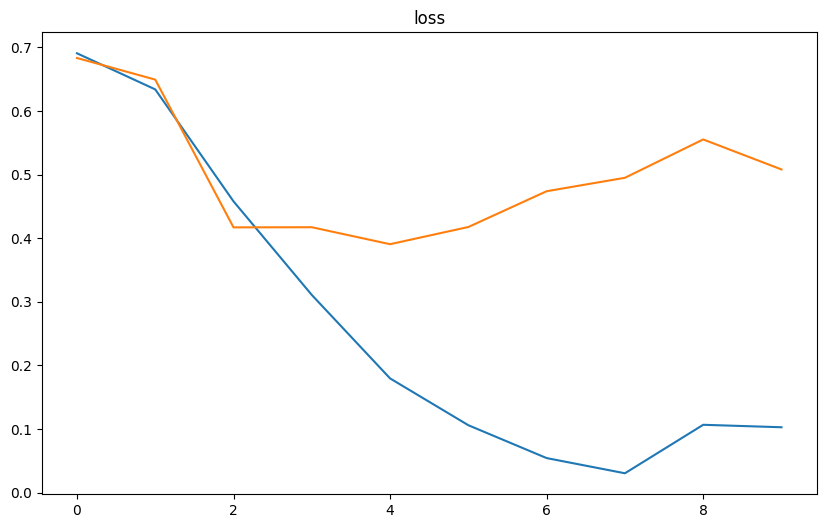

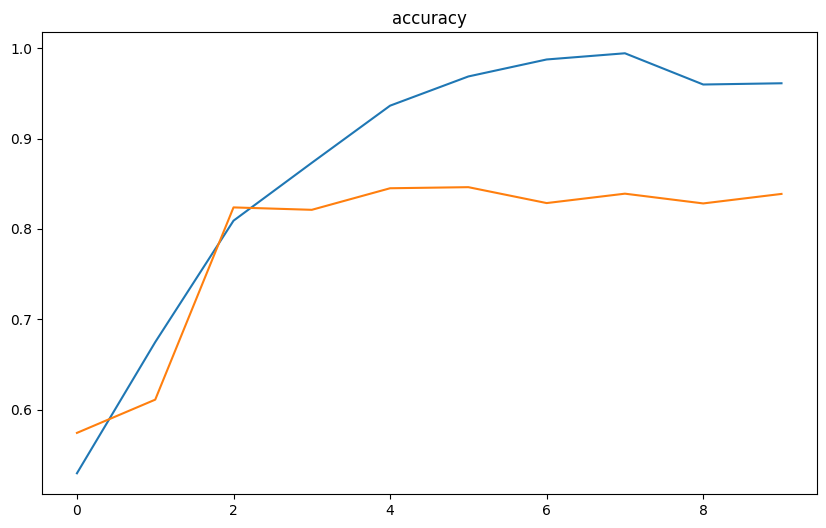

In [33]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## LSTM and GRU
In this Section, I will implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                1728      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101745 (397.44 KB)
Trainable params: 101745 (397.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
137/137 [==============================] - 18s 116ms/step - loss: 0.6185 - accuracy: 0.6781 - val_loss: 0.5335 - val_accuracy: 0.7959
Epoch 2/10
137/137 [==============================] - 13s 91ms/step - loss: 0.3870 - accuracy: 0.8602 - val_loss: 0.3375 - val_accura

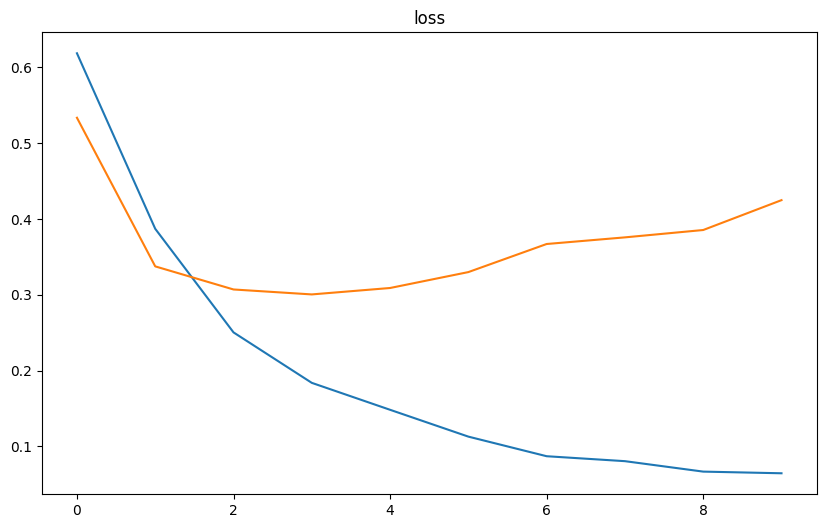

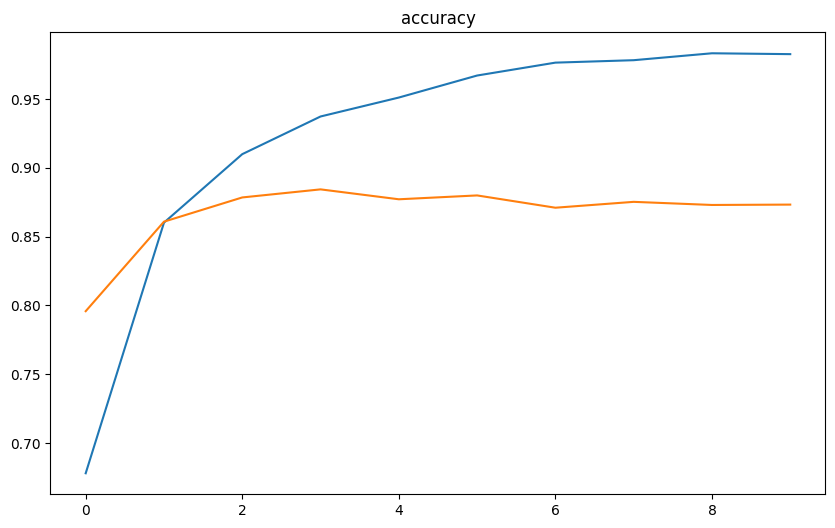

In [34]:
# LSTM - complete with model definition, summary, fit and plots.

model2 = keras.models.Sequential()
model2.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model2.add(keras.layers.LSTM(16))
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])


model2.summary()


history2 = model2.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history2)

plot_accuracy(history2)

scores2 = model2.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru_1 (GRU)                 (None, 16)                1344      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 101361 (395.94 KB)
Trainable params: 101361 (395.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
137/137 [==============================] - 19s 125ms/step - loss: 0.6166 - accuracy: 0.6489 - val_loss: 0.4004 - val_accuracy: 0.8259
Epoch 2/10
137/137 [==============================] - 13s 93ms/step - loss: 0.3262 - accuracy: 0.8650 - val_loss: 0.3228 - val_accura

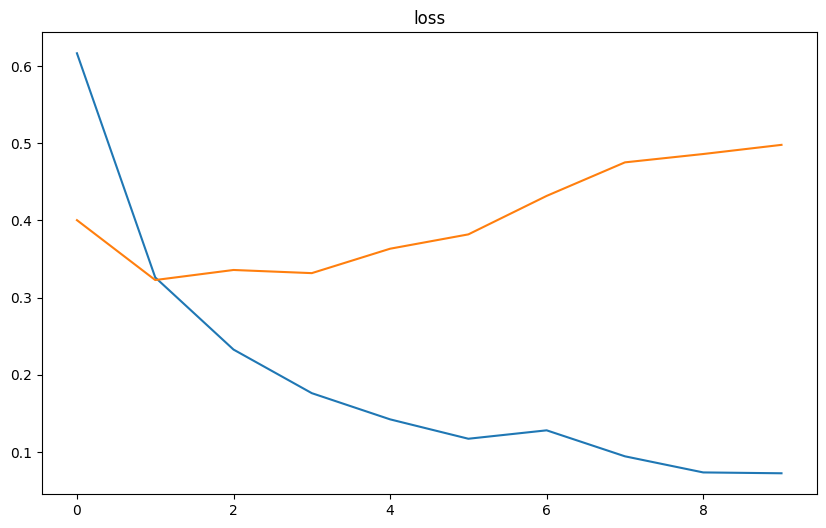

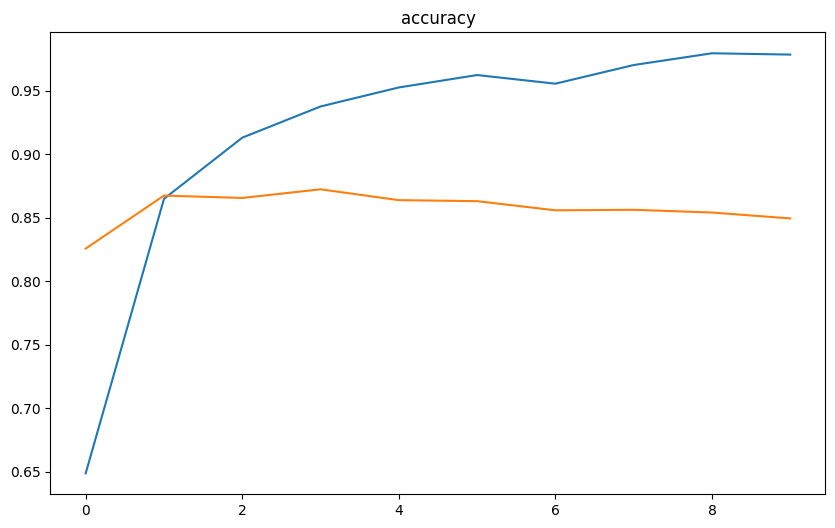

In [35]:
# GRU - complete with model definition, summary, fit and plots.

model3 = keras.models.Sequential()
model3.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model3.add(keras.layers.GRU(16))
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

model3.compile(loss = 'binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model3.summary()


history3 = model3.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


plot_loss(history3)

plot_accuracy(history3)

scores3 = model3.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model3.metrics_names[1], scores3[1]*100))

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [36]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                11008     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 111073 (433.88 KB)
Trainable params: 111073 (433.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
137/137 [==============================] - 23s 139ms/step - loss: 0.6455 - accuracy: 0.6146 - val_loss: 0.5016 - val_accuracy: 0.7804
Epoch 2/5
137/137 [==============================] - 18s 129ms/step 

782/782 - 10s - loss: 0.3528 - accuracy: 0.8696 - 10s/epoch - 13ms/step
accuracy: 86.96%


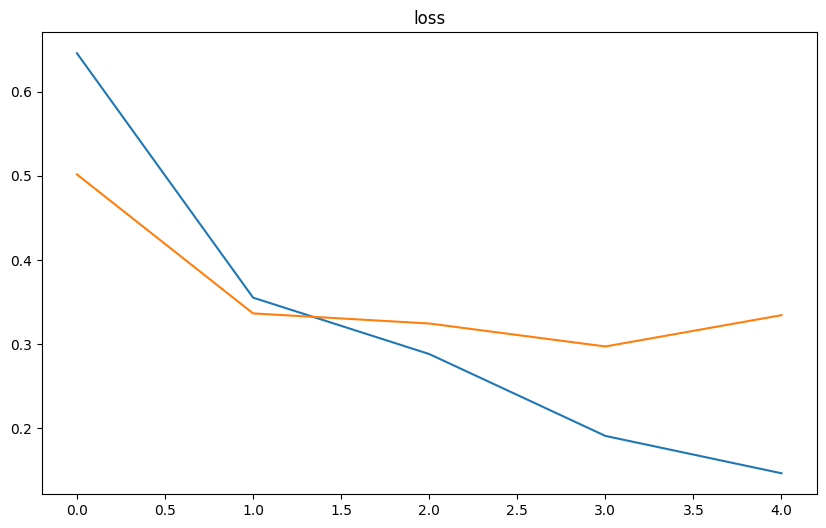

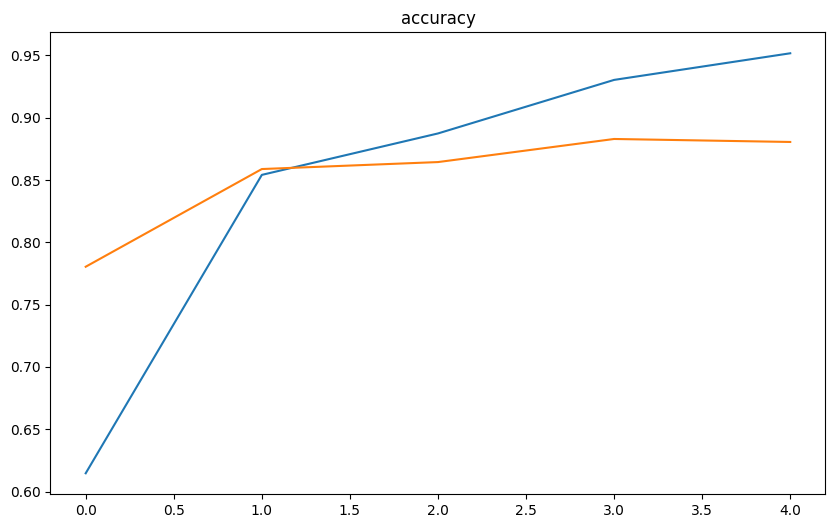

In [37]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Transformer

In [38]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [39]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [40]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.



In [41]:
embed_dim = 8  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/5
137/137 [==============================] - 21s 120ms/step - loss: 0.6042 - accuracy: 0.6471 - val_loss: 0.3591 - val_accuracy: 0.8459
Epoch 2/5
137/137 [==============================] - 13s 98ms/step - loss: 0.2959 - accuracy: 0.8853 - val_loss: 0.2927 - val_accuracy: 0.8788
Epoch 3/5
137/137 [==============================] - 8s 62ms/step - loss: 0.2052 - accuracy: 0.9254 - val_loss: 0.3058 - val_accuracy: 0.8755
Epoch 4/5
137/137 [==============================] - 7s 53ms/step - loss: 0.1547 - accuracy: 0.9482 - val_loss: 0.3414 - val_accuracy: 0.8737
Epoch 5/5
137/137 [==============================] - 8s 58ms/step - loss: 0.1214 - accuracy: 0.9605 - val_loss: 0.3953 - val_accuracy: 0.8715
782/782 - 4s - loss: 0.4350 - accuracy: 0.8555 - 4s/epoch - 5ms/step
accuracy: 85.55%


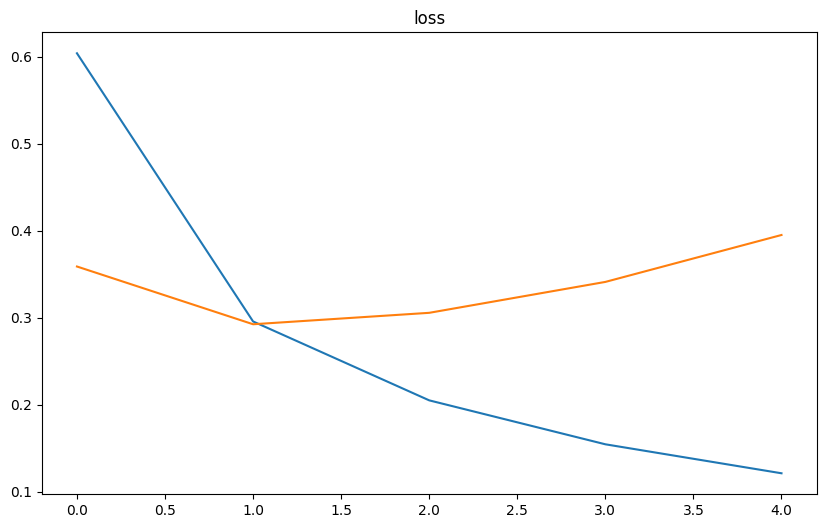

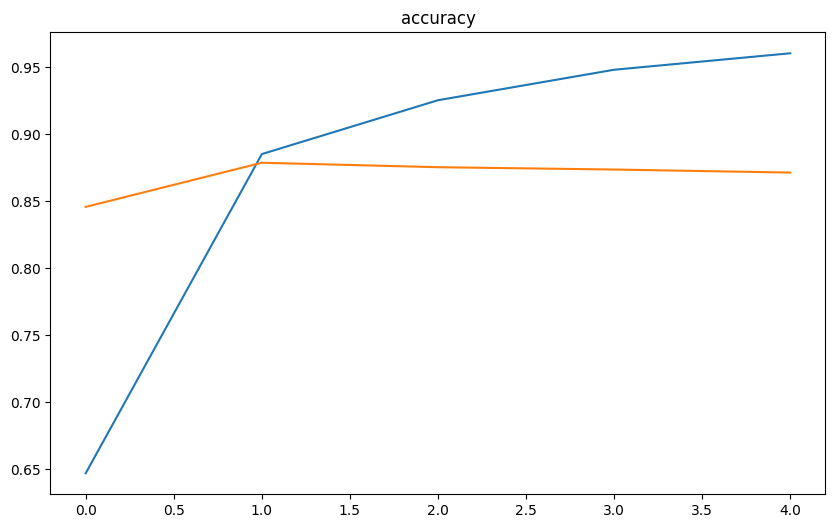

In [43]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)